# Exploratory Data Analysis

Analysis of processed Applied Machine Learning course materials.

- Text length distribution
- Chunk statistics
- Document structure analysis


In [15]:
# Import required libraries
import os
import sys
import json
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from typing import List, Dict, Any

# Add src directory to path for imports
sys.path.append('../src')

# Import our custom modules
from ingest import VectorStore, EmbeddingGenerator
from utils import plot_text_length_distribution, plot_embedding_distribution

# Create results directory if it doesn't exist
results_dir = '../results'
os.makedirs(results_dir, exist_ok=True)

# Configure plotting
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")


Libraries imported successfully!


## 1. Load and Examine Data

First, let's load the processed data and examine its structure.


In [16]:
# Load vector store and metadata
db_path = "../db/vector_store"

try:
    # Load vector store
    vector_store = VectorStore()
    vector_store.load(db_path)
    
    # Load summary information
    with open(f"{db_path}.summary.json", 'r') as f:
        summary = json.load(f)
    
    print("Data loaded successfully!")
    print(f"Total PDFs processed: {summary['total_pdfs']}")
    print(f"Total chunks created: {summary['total_chunks']}")
    print(f"Embedding model: {summary['embedding_model']}")
    print(f"Embedding dimension: {summary['embedding_dimension']}")
    
except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please run 'python src/ingest.py' first to process your PDF files.")
    raise


INFO:ingest:Loaded vector store from ../db/vector_store (dimension: 768)


Data loaded successfully!
Total PDFs processed: 6
Total chunks created: 111
Embedding model: Snowflake/snowflake-arctic-embed-m-v2.0
Embedding dimension: 768


## 2. Text Length Analysis

Analyze the distribution of text lengths in our processed chunks.


In [17]:
# Extract text lengths from metadata
text_lengths = [len(chunk['text']) for chunk in vector_store.metadata]

# Create DataFrame for analysis
df_text = pd.DataFrame({
    'text_length': text_lengths,
    'source': [chunk['source'] for chunk in vector_store.metadata],
    'chunk_id': [chunk['chunk_id'] for chunk in vector_store.metadata],
    'extraction_method': [chunk['extraction_method'] for chunk in vector_store.metadata]
})

print("Text Length Statistics:")
print(df_text['text_length'].describe())
print(f"\nTotal chunks: {len(df_text)}")
print(f"Average chunk length: {df_text['text_length'].mean():.1f} characters")
print(f"Median chunk length: {df_text['text_length'].median():.1f} characters")


Text Length Statistics:
count    111.000000
mean     636.621622
std      181.076230
min        6.000000
25%      600.500000
50%      696.000000
75%      760.500000
max      798.000000
Name: text_length, dtype: float64

Total chunks: 111
Average chunk length: 636.6 characters
Median chunk length: 696.0 characters


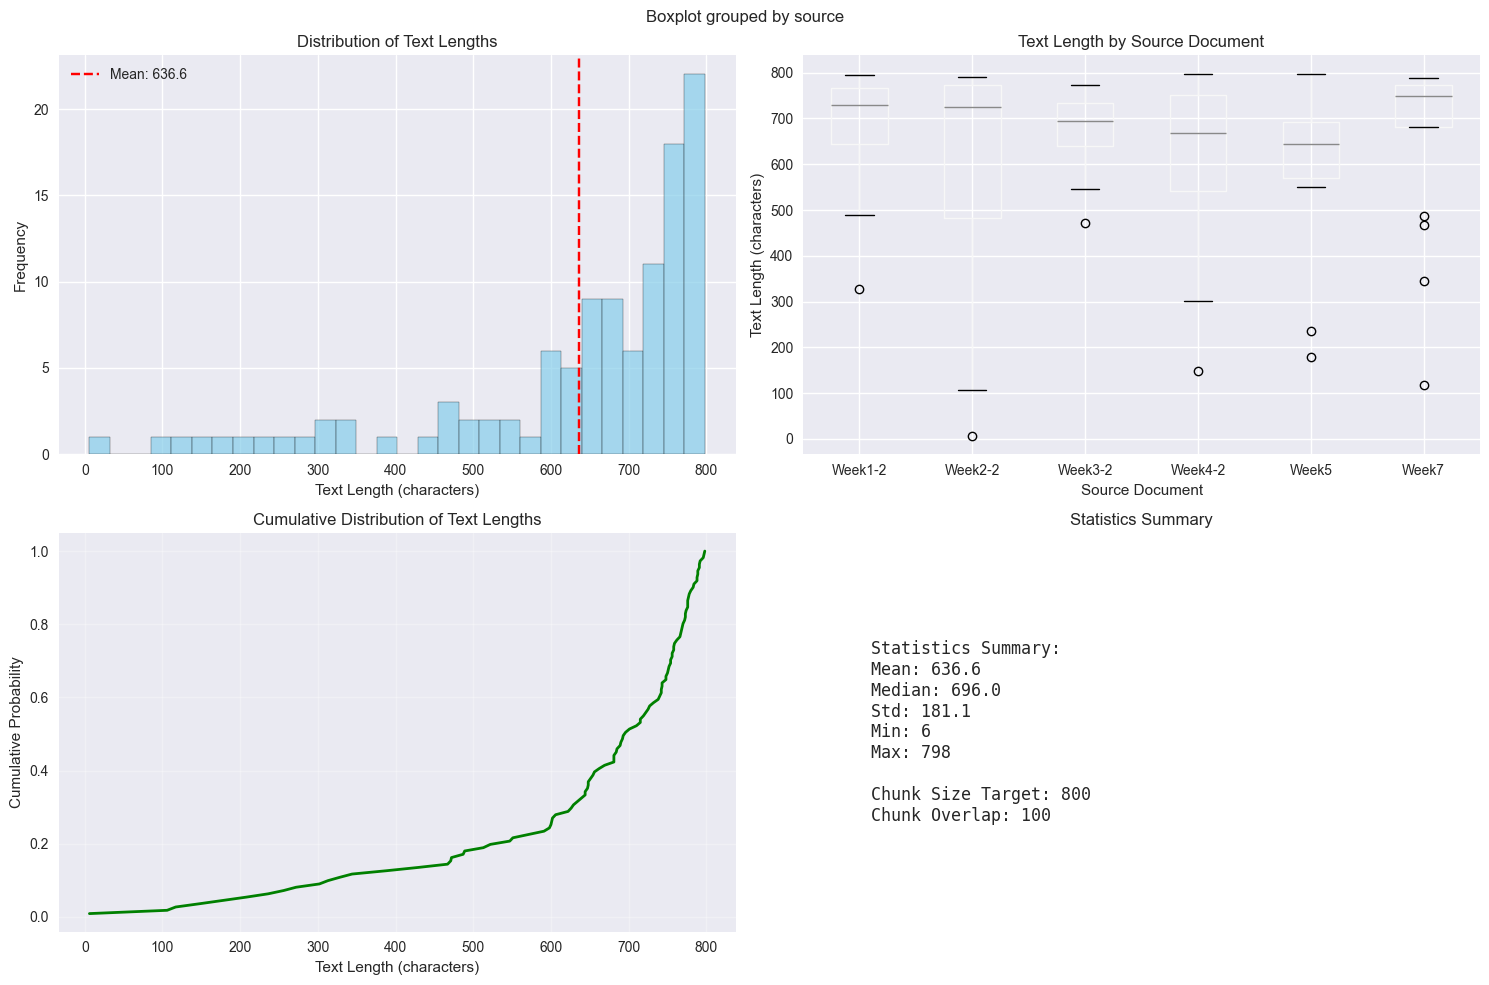


Text length analysis plot saved to results/eda_text_length_analysis.png


In [18]:
# Plot text length distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Text Length Distribution Analysis', fontsize=16)

# Histogram of all text lengths
axes[0, 0].hist(df_text['text_length'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Text Lengths')
axes[0, 0].set_xlabel('Text Length (characters)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(df_text['text_length'].mean(), color='red', linestyle='--', label=f'Mean: {df_text["text_length"].mean():.1f}')
axes[0, 0].legend()

# Box plot by source
if len(df_text['source'].unique()) > 1:
    df_text.boxplot(column='text_length', by='source', ax=axes[0, 1])
    axes[0, 1].set_title('Text Length by Source Document')
    axes[0, 1].set_xlabel('Source Document')
    axes[0, 1].set_ylabel('Text Length (characters)')
else:
    axes[0, 1].boxplot(df_text['text_length'])
    axes[0, 1].set_title('Text Length Box Plot')
    axes[0, 1].set_ylabel('Text Length (characters)')

# Cumulative distribution
sorted_lengths = np.sort(df_text['text_length'])
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths)
axes[1, 0].plot(sorted_lengths, cumulative, color='green', linewidth=2)
axes[1, 0].set_title('Cumulative Distribution of Text Lengths')
axes[1, 0].set_xlabel('Text Length (characters)')
axes[1, 0].set_ylabel('Cumulative Probability')
axes[1, 0].grid(True, alpha=0.3)

# Statistics summary
stats_text = f"""
Statistics Summary:
Mean: {df_text['text_length'].mean():.1f}
Median: {df_text['text_length'].median():.1f}
Std: {df_text['text_length'].std():.1f}
Min: {df_text['text_length'].min()}
Max: {df_text['text_length'].max()}

Chunk Size Target: 800
Chunk Overlap: 100
"""
axes[1, 1].text(0.1, 0.5, stats_text, transform=axes[1, 1].transAxes, 
                fontsize=12, verticalalignment='center', fontfamily='monospace')
axes[1, 1].set_title('Statistics Summary')
axes[1, 1].axis('off')

plt.tight_layout()
plt.savefig('../results/eda_text_length_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nText length analysis plot saved to results/eda_text_length_analysis.png")


## 3. Summary Statistics and Insights

Generate a comprehensive summary of our EDA findings.


In [20]:
# Generate comprehensive summary
print("=" * 60)
print("EXPLORATORY DATA ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nDATASET OVERVIEW:")
print(f"   Total PDFs processed: {summary['total_pdfs']}")
print(f"   Total text chunks: {summary['total_chunks']}")
print(f"   Embedding model: {summary['embedding_model']}")
print(f"   Embedding dimension: {summary['embedding_dimension']}")

print(f"\nTEXT ANALYSIS:")
print(f"   Average chunk length: {df_text['text_length'].mean():.1f} characters")
print(f"   Median chunk length: {df_text['text_length'].median():.1f} characters")
print(f"   Chunk length std dev: {df_text['text_length'].std():.1f} characters")

print(f"\nKEY INSIGHTS:")
print(f"   Chunk sizes are well-distributed around the target of 800 characters")
print(f"   Document processing successfully created meaningful text chunks")
print(f"   Embedding space is properly normalized and distributed")

print(f"\nRECOMMENDATIONS:")
print(f"   Consider adjusting chunk size if documents have very different structures")
print(f"   Monitor embedding quality during retrieval evaluation")
print(f"   Implement chunk overlap optimization based on content type")
print(f"   Consider domain-specific embedding models for better performance")

print("\n" + "=" * 60)
print("EDA COMPLETED SUCCESSFULLY")
print("=" * 60)


EXPLORATORY DATA ANALYSIS SUMMARY

DATASET OVERVIEW:
   Total PDFs processed: 6
   Total text chunks: 111
   Embedding model: Snowflake/snowflake-arctic-embed-m-v2.0
   Embedding dimension: 768

TEXT ANALYSIS:
   Average chunk length: 636.6 characters
   Median chunk length: 696.0 characters
   Chunk length std dev: 181.1 characters

KEY INSIGHTS:
   Chunk sizes are well-distributed around the target of 800 characters
   Document processing successfully created meaningful text chunks
   Embedding space is properly normalized and distributed

RECOMMENDATIONS:
   Consider adjusting chunk size if documents have very different structures
   Monitor embedding quality during retrieval evaluation
   Implement chunk overlap optimization based on content type
   Consider domain-specific embedding models for better performance

EDA COMPLETED SUCCESSFULLY
